In [2]:
import json

data_path = '../data/UNIMIB2016'
annotations = json.load(open(os.path.join(data_path, "annotation.json")))
annotations = [v for k,v in annotations.items()]
print(len(annotations))
objects = [annotation['regions']  for annotation in annotations]

categories = [v['region_attributes']['category']  for object in objects for k,v in object.items()]
print(len(categories))
# print(categories)
classes = json.load(open(os.path.join(data_path, "classes.json")))

count = [0 for i in range(len(classes)+1)]
for category in categories:
    index = classes[category]
    count[index] += 1
count = count[1:]
print(count)

1027
3616
[66, 62, 15, 22, 17, 112, 161, 11, 7, 148, 3, 131, 37, 12, 3, 17, 1, 46, 66, 198, 56, 73, 10, 3, 12, 39, 479, 6, 11, 64, 5, 16, 45, 42, 70, 39, 16, 65, 80, 31, 30, 52, 151, 49, 64, 35, 9, 17, 26, 89, 38, 45, 57, 31, 7, 7, 1, 21, 93, 110, 13, 1, 2, 3, 6, 7, 22, 25, 48, 54, 130, 9, 67]


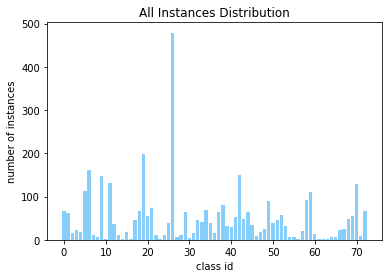

In [3]:
import matplotlib.pyplot as plt

plt.bar(range(len(count)), count,  color="#87CEFA")  
# 设置横轴标签
plt.xlabel('class id')
# 设置纵轴标签
plt.ylabel('number of instances')
# 添加标题
plt.title('All Instances Distribution')
# 添加纵横轴的刻度
# plt.xticks(range(len(count)))
# plt.yticks(np.arange(0, 10000, 10))
plt.savefig('unimib.png', dpi=300)
plt.show()  

In [4]:
import json

data_path = '../data/UNIMIB2016'
annotations = json.load(open(os.path.join(data_path, "test_region_data.json")))
annotations = [v for k,v in annotations.items()]
print(len(annotations))
objects = [annotation['regions']  for annotation in annotations]

categories = [v['region_attributes']['category']  for object in objects for k,v in object.items()]
print(len(categories))
# print(categories)
classes = json.load(open(os.path.join(data_path, "classes.json")))

count = [0 for i in range(len(classes)+1)]
for category in categories:
    index = classes[category]
    count[index] += 1
count = count[1:]
print(count)

360
1254
[19, 24, 6, 9, 6, 40, 59, 5, 2, 52, 0, 48, 12, 4, 0, 6, 0, 19, 27, 62, 22, 28, 1, 0, 3, 11, 172, 2, 5, 26, 2, 7, 18, 17, 25, 14, 7, 21, 24, 12, 12, 15, 47, 17, 22, 13, 3, 2, 9, 31, 13, 11, 21, 12, 3, 2, 0, 6, 33, 41, 5, 0, 0, 0, 3, 3, 7, 7, 15, 18, 46, 4, 16]


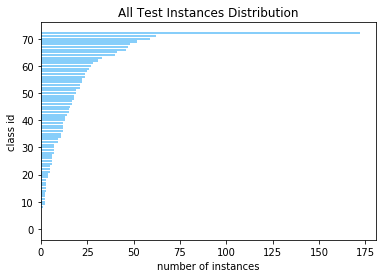

In [11]:
import matplotlib.pyplot as plt
count.sort()
plt.barh(range(len(count)), count,  color="#87CEFA")  
# 设置横轴标签
plt.ylabel('class id')
# 设置纵轴标签
plt.xlabel('number of instances')
# 添加标题
plt.title('All Test Instances Distribution')
# 添加纵横轴的刻度
# plt.xticks(range(len(count)))
# plt.yticks(np.arange(0, 10000, 10))
plt.savefig('test_unimib.png', dpi=300)
plt.show()

In [2]:
import torch
import os
os.chdir('/home/hatsunemiku/dev/mask-rcnn')

import utils
import transforms as T
from dataloader import UNIMIBDataset
from engine import train_one_epoch, evaluate
from model import get_model_instance_segmentation

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 74
# use our dataset and defined transformations
dataset_test = UNIMIBDataset('/home/hatsunemiku/dev/mask-rcnn/data/UNIMIB2016', get_transform(train=False), False)

data_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
model.load_state_dict(torch.load('./models/0112/model.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
import math
import sys
import time
import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


n_threads = torch.get_num_threads()
# FIXME remove this and make paste_masks_in_image run on the GPU
torch.set_num_threads(1)
cpu_device = torch.device("cpu")
model.eval()
metric_logger = utils.MetricLogger(delimiter="  ")
header = 'Test:'

coco = get_coco_api_from_dataset(data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

for images, targets in metric_logger.log_every(data_loader, 100, header):
    images = list(img.to(device) for img in images)

    torch.cuda.synchronize()
    model_time = time.time()
    outputs = model(images)

    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    model_time = time.time() - model_time

    res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
    evaluator_time = time.time()
    coco_evaluator.update(res)
    evaluator_time = time.time() - evaluator_time
    metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

# gather the stats from all processes
metric_logger.synchronize_between_processes()
print("Averaged stats:", metric_logger)
coco_evaluator.synchronize_between_processes()

# accumulate predictions from all images
coco_evaluator.accumulate()
coco_evaluator.summarize()
torch.set_num_threads(n_threads)

creating index...
index created!
Test:  [  0/360]  eta: 0:07:27  model_time: 0.2461 (0.2461)  evaluator_time: 0.2228 (0.2228)  time: 1.2433  data: 0.7422  max mem: 1647
Test:  [100/360]  eta: 0:04:14  model_time: 0.1645 (0.1706)  evaluator_time: 0.1315 (0.1435)  time: 0.9828  data: 0.6654  max mem: 2962
Test:  [200/360]  eta: 0:02:32  model_time: 0.1887 (0.1636)  evaluator_time: 0.1664 (0.1339)  time: 1.0009  data: 0.6409  max mem: 2962
Test:  [300/360]  eta: 0:00:57  model_time: 0.1403 (0.1624)  evaluator_time: 0.1010 (0.1318)  time: 0.9268  data: 0.6543  max mem: 2962
Test:  [359/360]  eta: 0:00:00  model_time: 0.1498 (0.1595)  evaluator_time: 0.1031 (0.1277)  time: 0.8893  data: 0.6018  max mem: 2962
Test: Total time: 0:05:40 (0.9448 s / it)
Averaged stats: model_time: 0.1498 (0.1595)  evaluator_time: 0.1031 (0.1277)
Accumulating evaluation results...
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.31s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=

In [34]:
import numpy as np
import matplotlib.pyplot as plt

draw_list = [0.5,0.75,0.8,0.85,0.9,0.95]
for iou_type, coco_eval in coco_evaluator.coco_eval.items():
    # pr_array = coco_eval.eval['precision'][0, :, 1:, 0, 2]
    # print(pr_array.shape)
    # pr_array = np.mean(pr_array,axis=1)
    # print(pr_array.shape)
    for i in range(10):
        pr_array = coco_eval.eval['precision'][i, :, :, 0, 2]
        # pr_array1 = coco_eval.eval['precision'][0, :, :, 0, 2]
        # pr_array2 = coco_eval.eval['precision'][5, :, :, 0, 2]
        # pr_array3 = coco_eval.eval['precision'][8, :, :, 0, 2]
        pr_array = np.mean(pr_array,axis=1)

        # pr_array1 = np.mean(pr_array1,axis=1)
        # pr_array2 = np.mean(pr_array2,axis=1)
        # pr_array3 = np.mean(pr_array3,axis=1)
        x = np.arange(0.0, 1.01, 0.01)
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.xlim(0, 1.0)
        plt.ylim(0, 1.01)
        plt.grid(True)

        # plt.plot(x, pr_array1, 'b-', label='IoU=0.5')
        # plt.plot(x, pr_array2, 'c-', label='IoU=0.75')
        # plt.plot(x, pr_array3, 'y-', label='IoU=0.9')
        iou = round(0.5+0.05*i, 2)
        if iou in draw_list:
            plt.plot(x, pr_array, label='IoU='+str(iou))

    plt.legend(loc="lower left")
    plt.savefig("pr_curve_{}.jpg".format(iou_type), dpi=300)  #输入地址，并利用format函数修改图片名称
    plt.clf() #需要重新更新画布，否则会出现同一张画布上绘制多张图片


    print(coco_eval.eval['recall'].shape)
    for i in range(3):
        recall_array = coco_eval.eval['recall'][:, :, 0, i]
        recall_array = np.mean(recall_array, axis=1)
        x = np.arange(0.5, 1.0, 0.05)
        plt.xlabel('IoU')
        plt.ylabel('recall')
        plt.xlim(0.5, 0.95)
        plt.ylim(0, 1.01)
        plt.grid(True)

        plt.plot(x, recall_array, label='maxDets='+str(10**i))
    plt.legend(loc="lower left")
    plt.savefig("recall_iou_curve_{}.jpg".format(iou_type), dpi=300)  #输入地址，并利用format函数修改图片名称
    plt.clf() #需要重新更新画布，否则会出现同一张画布上绘制多张图片

(10, 65, 4, 3)
(10, 65, 4, 3)


<Figure size 432x288 with 0 Axes>